# **SE CONNECTER SUR DRIVE AVEC GOOGLE COLLAB **


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPORTER LES LIBRIRIRES ****

In [ ]:
# First Cell: Import Libraries
import numpy as np
import nibabel as nib
import os
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
!gdown https://drive.google.com/uc?id=16-bZCe4whMnMfBjXBZwhPS16Uxet_x07
!unzip testing

!gdown https://drive.google.com/uc?id=17gb7VFUgoHzUWc3eH_gxdmNekLLZQEIO
!unzip training


Downloading...
From: https://drive.google.com/uc?id=16-bZCe4whMnMfBjXBZwhPS16Uxet_x07
To: /content/testing.zip
100% 2.40M/2.40M [00:00<00:00, 154MB/s]
Archive:  testing.zip
   creating: testing/
  inflating: testing/mask_0053.nii.gz  
  inflating: testing/T1_0052.nii.gz  
  inflating: testing/mask_0030.nii.gz  
  inflating: testing/T1_0031.nii.gz  
  inflating: testing/T1_0040.nii.gz  
  inflating: testing/mask_0041.nii.gz  
  inflating: testing/T1_0023.nii.gz  
  inflating: testing/mask_0022.nii.gz  
  inflating: testing/T1_0015.nii.gz  
  inflating: testing/mask_0014.nii.gz  
  inflating: testing/T1_0068.nii.gz  
  inflating: testing/mask_0018.nii.gz  
  inflating: testing/T1_0019.nii.gz  
  inflating: testing/mask_0065.nii.gz  
  inflating: testing/T1_0064.nii.gz  
  inflating: testing/mask_0006.nii.gz  
  inflating: testing/T1_0007.nii.gz  
  inflating: testing/T1_0021.nii.gz  
  inflating: testing/mask_0020.nii.gz  
  inflating: testing/T1_0042.nii.gz  
  inflating: testing/mask_0

# **Step 2: Helper Function to Load Data
**

In [ ]:
# Second Cell: Helper Function to Load Data
def read_image_nii(folder, index):
    t1 = nib.load(os.path.join(folder, 'T1_' + str(index).zfill(4) + '.nii.gz'))
    mask = nib.load(os.path.join(folder, 'mask_' + str(index).zfill(4) + '.nii.gz'))
    t1_data = t1.get_fdata()
    mask_data = mask.get_fdata()
    return t1_data, mask_data

def load_data(folder):
    X, Y = [], []
    files = os.listdir(folder)
    num_images = len([f for f in files if 'mask' not in f])

    for i in range(num_images):
        t1_data, mask_data = read_image_nii(folder, i)
        X.append(np.expand_dims(t1_data, axis=-1))
        Y.append(np.expand_dims(mask_data, axis=-1))

    return np.array(X), np.array(Y)


In [ ]:
# Third Cell: Load Training Data
X_train, Y_train = load_data("/content/training/")



# **Step 4: Define the U-Net Model**

In [ ]:
# Fourth Cell: Define U-Net Model Function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Lambda

def create_unet_model(input_size=(128, 128, 1), drop_out=0.0):
    inputs = Input(input_size)

    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(drop_out)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(drop_out)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(drop_out)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(drop_out)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(drop_out)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(drop_out)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(drop_out)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(drop_out)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(drop_out)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# **Step 5: K-Fold Cross-Validation Setup**

In [ ]:
# Fifth Cell: K-Fold Cross-Validation Setup
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)



# **Step 6: Train Model within K-Fold Loop**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
# Sixth Cell: Train Model within K-Fold Loop
fold_var = 1
for train_idx, val_idx in kf.split(X_train):
    print(f"Training on fold {fold_var}/{n_splits}...")

    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

    # Create and compile model
    model = create_unet_model()
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), batch_size=1, epochs=10)
    checkpoint = ModelCheckpoint(f'model_trainig.h5', save_best_only=True, monitor='val_loss', mode='min')


    fold_var += 1


Training on fold 1/2...
Epoch 1/10
73/73 [==============================] - 23s 250ms/step - loss: 0.2441 - accuracy: 0.9057 - val_loss: 0.0883 - val_accuracy: 0.9647
Epoch 2/10
73/73 [==============================] - 20s 275ms/step - loss: 0.0817 - accuracy: 0.9686 - val_loss: 0.0744 - val_accuracy: 0.9727
Epoch 3/10
73/73 [==============================] - 20s 269ms/step - loss: 0.0634 - accuracy: 0.9761 - val_loss: 0.0794 - val_accuracy: 0.9691
Epoch 4/10
73/73 [==============================] - 18s 251ms/step - loss: 0.0745 - accuracy: 0.9706 - val_loss: 0.0822 - val_accuracy: 0.9623
Epoch 5/10
73/73 [==============================] - 19s 262ms/step - loss: 0.0443 - accuracy: 0.9834 - val_loss: 0.0588 - val_accuracy: 0.9793
Epoch 6/10
73/73 [==============================] - 20s 281ms/step - loss: 0.0474 - accuracy: 0.9827 - val_loss: 0.0444 - val_accuracy: 0.9805
Epoch 7/10
73/73 [==============================] - 20s 272ms/step - loss: 0.0237 - accuracy: 0.9914 - val_loss: 0.027

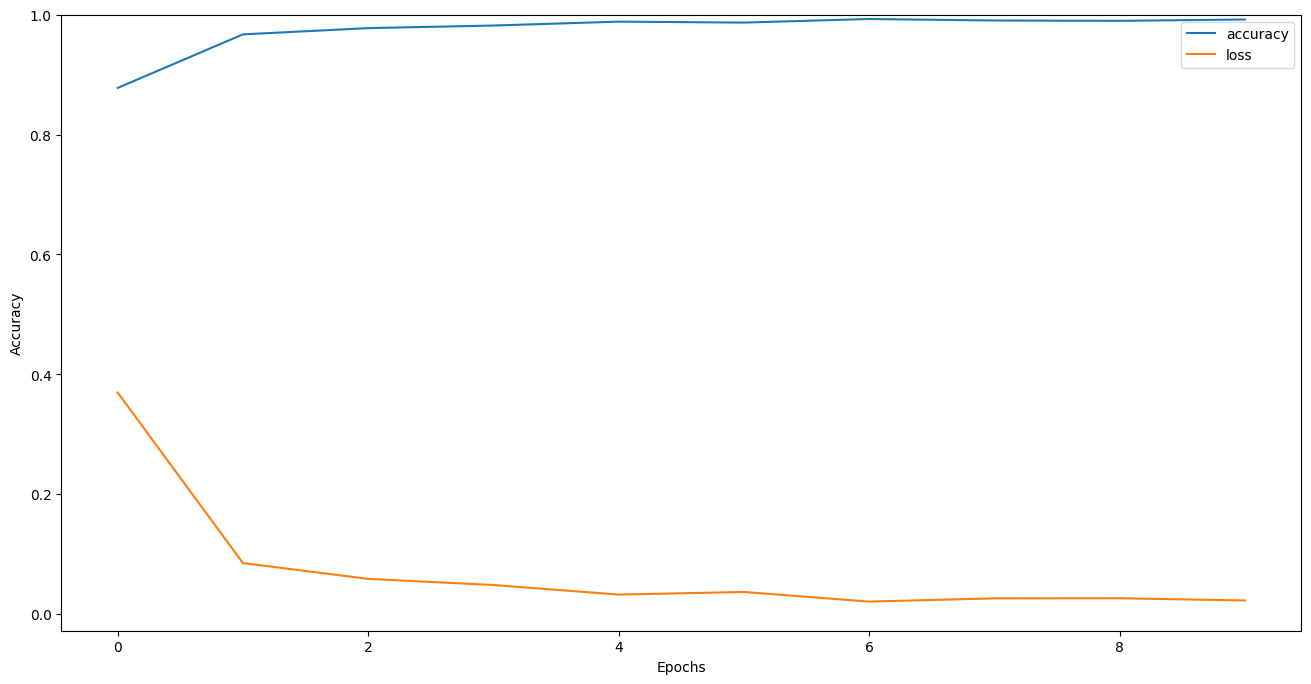

In [ ]:
# Learning curve (Accuracy and loss on training dataset)
plt.figure(figsize=(16,8))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["loss"], label="loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(ymax=1)  # this line
plt.legend()

# **Step 7: Load Testing Data**

In [ ]:
# Seventh Cell: Load Testing Data
X_test, Y_test = load_data("/content/testing/")

In [ ]:
from scipy.spatial.distance import directed_hausdorff

# Custom Dice Coefficient and Hausdorff Distance Functions
def dice(pred, true):
    intersection = np.sum(pred[true==1]) * 2.0
    dice_score = intersection / (np.sum(pred) + np.sum(true))
    return dice_score

def hausdorff_distance(pred, true):
    # Reshape the flattened arrays back into 2D arrays
    pred_reshaped = pred.reshape((128, 128))
    true_reshaped = true.reshape((128, 128))

    # Convert the 2D arrays into a set of points (list of coordinates)
    pred_points = np.argwhere(pred_reshaped)
    true_points = np.argwhere(true_reshaped)

    # Compute the directed Hausdorff distance
    haus = max(directed_hausdorff(pred_points, true_points)[0], directed_hausdorff(true_points, pred_points)[0])
    return haus

# **Step 8: Evaluate the Model**

3/3 [==============================] - 4s 1s/step


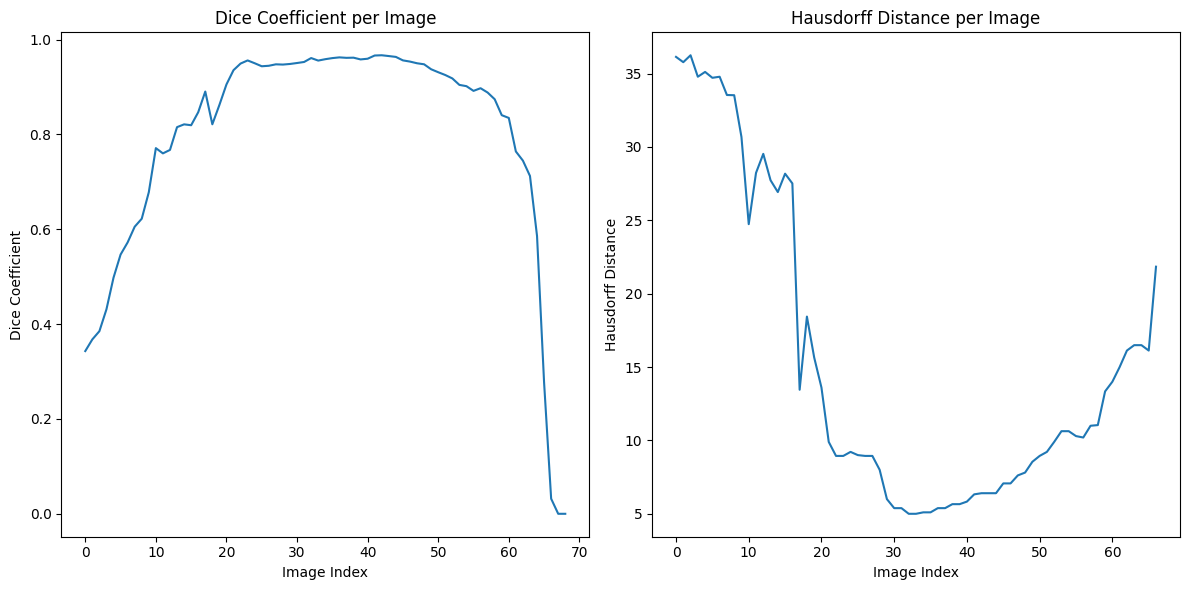

In [ ]:
# Eighth Cell: Evaluate the Model
test_preds = model.predict(X_test)
# Add your code here to process test_preds and evaluate the model based on your metrics.


# Convert predictions to binary
preds_test_thresh = (test_preds >= 0.6).astype(np.uint8)

# Initialize lists to store the metrics for each image
dice_scores = []
hausdorff_distances = []

# Calculate metrics for each image in the test set
for i in range(len(X_test)):
    dice_score = dice(preds_test_thresh[i].flatten(), Y_test[i].flatten())
    hausdorff_distance_val = hausdorff_distance(preds_test_thresh[i].flatten(), Y_test[i].flatten())

    dice_scores.append(dice_score)
    hausdorff_distances.append(hausdorff_distance_val)

# Plot the metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(dice_scores, label='Dice Coefficient')
plt.title('Dice Coefficient per Image')
plt.xlabel('Image Index')
plt.ylabel('Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(hausdorff_distances, label='Hausdorff Distance')
plt.title('Hausdorff Distance per Image')
plt.xlabel('Image Index')
plt.ylabel('Hausdorff Distance')

plt.tight_layout()
plt.show()

()
plt.show()


1/1 [==============================] - 0s 108ms/step


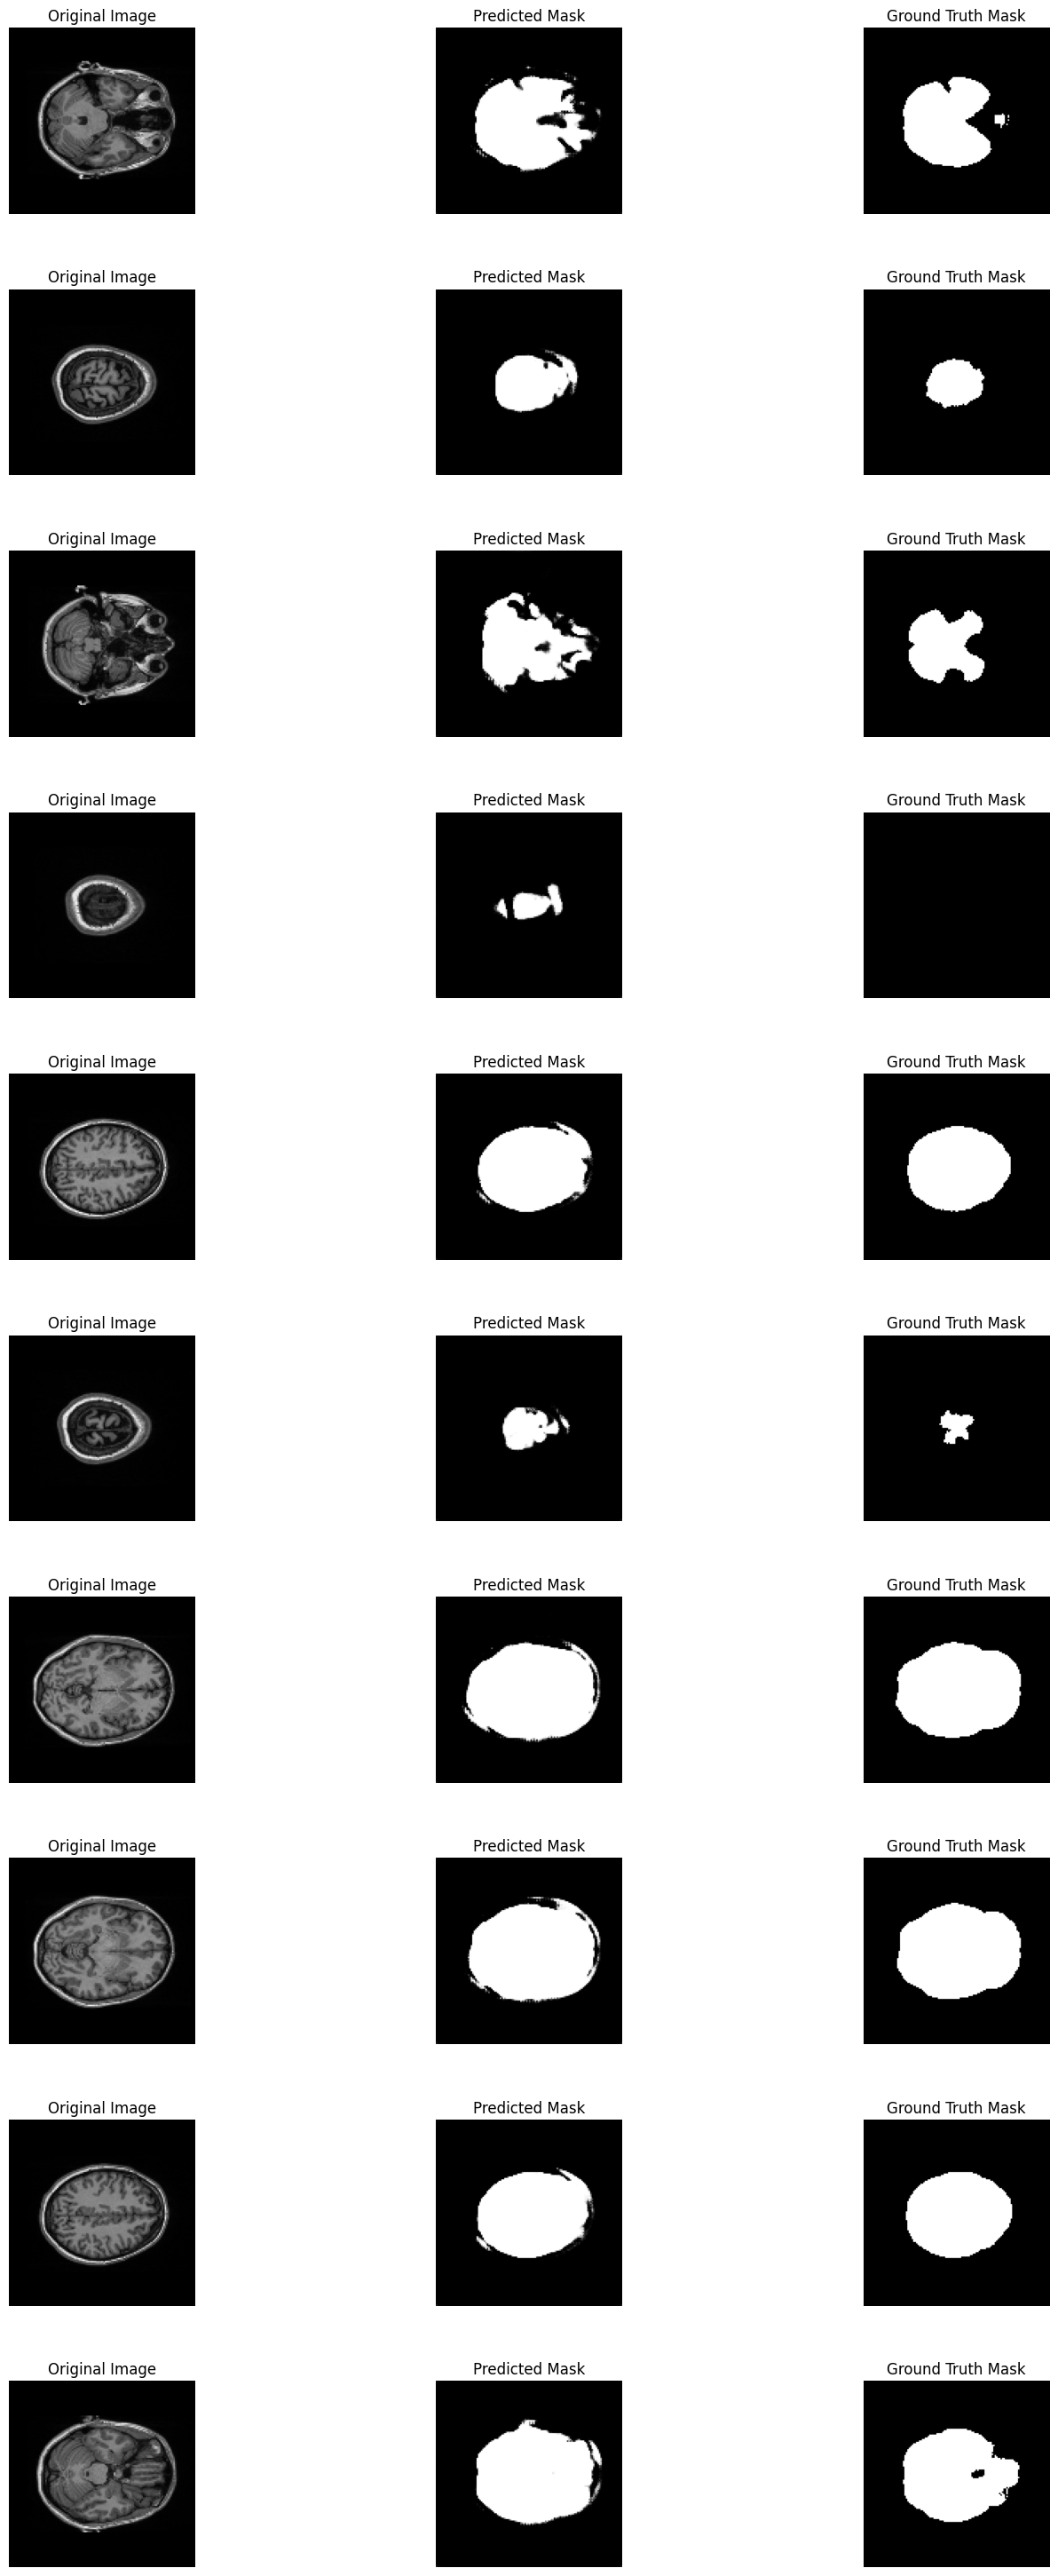

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def display_random_predictions_with_ground_truth(model, X, Y, num_images=10):
    # Select 10 random indices
    random_indices = random.sample(range(X.shape[0]), num_images)

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 3))
    fig.tight_layout(pad=4.0)

    for i, idx in enumerate(random_indices):
        # Predict the mask
        predicted_mask = model.predict(np.expand_dims(X[idx], axis=0))

        # Display original image
        axes[i, 0].imshow(X[idx].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Display predicted mask
        axes[i, 1].imshow(predicted_mask.squeeze(), cmap='gray')
        axes[i, 1].set_title('Predicted Mask')
        axes[i, 1].axis('off')

        # Display ground truth mask
        axes[i, 2].imshow(Y[idx].squeeze(), cmap='gray')
        axes[i, 2].set_title('Ground Truth Mask')
        axes[i, 2].axis('off')

    plt.show()

# Use the function with your model and test data
display_random_predictions_with_ground_truth(model, X_test, Y_test)
